Connect to Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd drive/MyDrive/instadeep/InstaDeep/

/content/drive/MyDrive/instadeep/InstaDeep


Packages import

In [5]:
from data import features,get_dataset
from model import classifier
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

GPU

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Data processing

In [7]:
path="random_split/"

test,val,train =get_dataset.get_df(path)

#Due to limitation of computing capacities, we will only consider the 1000 most important classes
classes=features.get_classes_top1000(train)
#apply those changes to train, test, val
test=features.reduce_dataset_1000topclasses(test,classes)
train=features.reduce_dataset_1000topclasses(train,classes)
val=features.reduce_dataset_1000topclasses(val,classes)

#Process inputs 
train_processed=features.process_dataset(train, classes)
test_processed=features.process_dataset(test, classes)
val_processed=features.process_dataset(val, classes)
print(train_processed.shape)
print(test_processed.shape)
print(val_processed.shape)
#Process labels
y_train=features.process_labels(train,classes)
y_test=features.process_labels(test,classes)
y_val=features.process_labels(val,classes)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(439493, 100)
(54378, 100)
(54378, 100)
(439493, 1000)
(54378, 1000)
(54378, 1000)


Simple model : using LSTM

In [8]:
model=classifier.build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2100      
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              201000    
Total params: 363,900
Trainable params: 363,900
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
history=classifier.train_model(model,train_processed,y_train,val_processed,y_val,epochs=50)


Epoch 1/50
1717/1717 [==============================] - 51s 27ms/step - loss: 7.3882 - accuracy: 0.0375 - val_loss: 3.8098 - val_accuracy: 0.2907
Epoch 2/50
1717/1717 [==============================] - 47s 27ms/step - loss: 3.4678 - accuracy: 0.3518 - val_loss: 1.9995 - val_accuracy: 0.6783
Epoch 3/50
1717/1717 [==============================] - 48s 28ms/step - loss: 2.1087 - accuracy: 0.6276 - val_loss: 1.3451 - val_accuracy: 0.8077
Epoch 4/50
1717/1717 [==============================] - 48s 28ms/step - loss: 1.6097 - accuracy: 0.7253 - val_loss: 1.0628 - val_accuracy: 0.8561
Epoch 5/50
1717/1717 [==============================] - 47s 28ms/step - loss: 1.3518 - accuracy: 0.7722 - val_loss: 0.8973 - val_accuracy: 0.8850
Epoch 6/50
1717/1717 [==============================] - 48s 28ms/step - loss: 1.1977 - accuracy: 0.8026 - val_loss: 0.7928 - val_accuracy: 0.9043
Epoch 7/50
1717/1717 [==============================] - 48s 28ms/step - loss: 1.0916 - accuracy: 0.8220 - val_loss: 0.7168 -

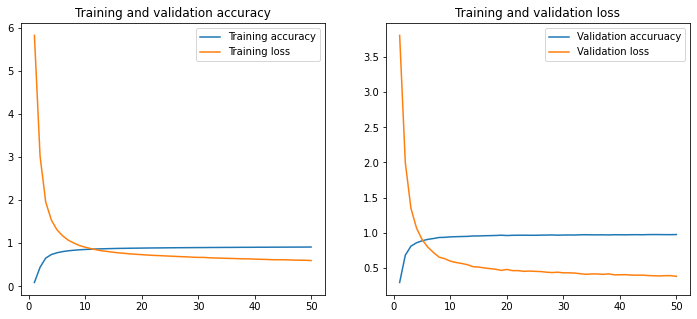

In [10]:
classifier.plot_accuracy_train_val(history)

In [11]:
result=model.evaluate(test_processed,y_test)

1700/1700 [==============================] - 11s 6ms/step - loss: 0.3789 - accuracy: 0.9731


ProtCNN

In [12]:
#additional preprocessing 
train_2=features.additional_process(train_processed)
val_2=features.additional_process(val_processed)
test_2=features.additional_process(test_processed)


In [13]:
model2=classifier.protccn_model(input_shape=train_2.shape)
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (439493, 100, 128)        2816      
_________________________________________________________________
sequential_2 (Sequential)    (439493, 100, 128)        66816     
_________________________________________________________________
sequential_3 (Sequential)    (439493, 100, 128)        66816     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (439493, 33, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (439493, 33, 128)         0         
_________________________________________________________________
flatten (Flatten)            (439493, 4224)            0         
_________________________________________________________________
dense_1 (Dense)              (439493, 1000)           

In [14]:
history2=classifier.train_model(model2,train_2,y_train,val_2,y_val,epochs=50,model_name="protCNN")

Epoch 1/50
1717/1717 [==============================] - 55s 30ms/step - loss: 1.6823 - accuracy: 0.8236 - val_loss: 0.4264 - val_accuracy: 0.9850
Epoch 2/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.3925 - accuracy: 0.9832 - val_loss: 0.4327 - val_accuracy: 0.9838
Epoch 3/50
1717/1717 [==============================] - 51s 29ms/step - loss: 0.4025 - accuracy: 0.9838 - val_loss: 0.4305 - val_accuracy: 0.9850
Epoch 4/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.4012 - accuracy: 0.9846 - val_loss: 0.4348 - val_accuracy: 0.9832
Epoch 5/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.3934 - accuracy: 0.9854 - val_loss: 0.4258 - val_accuracy: 0.9857
Epoch 6/50
1717/1717 [==============================] - 51s 29ms/step - loss: 0.3890 - accuracy: 0.9859 - val_loss: 0.4081 - val_accuracy: 0.9856
Epoch 7/50
1717/1717 [==============================] - 51s 29ms/step - loss: 0.3770 - accuracy: 0.9863 - val_loss: 0.4146 -

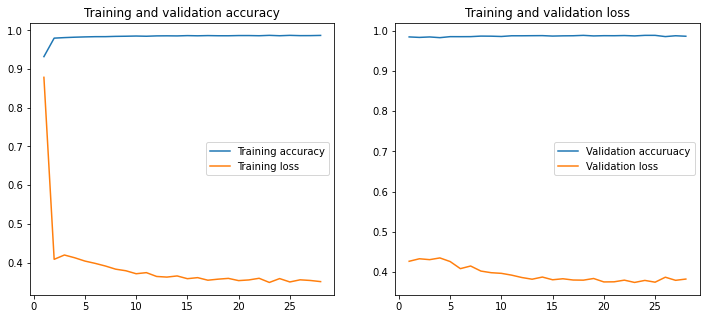

In [15]:
classifier.plot_accuracy_train_val(history2)

In [16]:
result=model2.evaluate(test_2,y_test)

1700/1700 [==============================] - 6s 3ms/step - loss: 0.3852 - accuracy: 0.9868
